# Параллельные вычисления

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html
* https://nalepae.github.io/pandarallel/
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_windows.ipynb
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_mac_linux.ipynb

## Задачи для совместного разбора

In [1]:
path = 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//'

In [2]:
!pip install pandarallel

Error processing line 1 of C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib-3.5.3-py3.10-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site.py", line 186, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 568, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 1 of C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib-3.6.0-py3.10-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site.py", line 186, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 568, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored

[notice] 

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"]. 

In [3]:
import multiprocessing

files = [f"{path}{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]

In [4]:
from collections import Counter

def count_a(file):
    with open(file, 'r', encoding='utf8') as fp:
        text = fp.read().lower()
    res = Counter(text)['a']
    print(file, res)
    return res

In [5]:
%%time
[count_a(f) for f in files]

C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//xaa.txt 2599627
C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//xab.txt 2605911
C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//xac.txt 2599868
C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//xad.txt 1460452
CPU times: total: 10.7 s
Wall time: 10.9 s


[2599627, 2605911, 2599868, 1460452]

In [6]:
%%file count_a.py
from collections import Counter

def count_a(file):
    with open(file, 'r', encoding='utf8') as fp:
        text = fp.read().lower()
    res = Counter(text)['a']
    print(file, res)
    return res

Writing count_a.py


In [7]:
from count_a import count_a

In [8]:
%%time
with multiprocessing.Pool(processes = 4) as pool:
    res = pool.map(count_a, files)
res    

CPU times: total: 15.6 ms
Wall time: 5.23 s


[2599627, 2605911, 2599868, 1460452]

In [9]:
%%file count_a_q.py
from collections import Counter

def count_a_q(file, queue):
    with open(file, 'r', encoding='utf8') as fp:
        text = fp.read().lower()
    res = Counter(text)['a']
    print(file, res)
    queue.put(res)

Writing count_a_q.py


In [10]:
from count_a_q import count_a_q

In [11]:
%%time
#not guarantee order
processes = []
queue = multiprocessing.Queue()

#args must be tuple
for f in files:
    process = multiprocessing.Process(target=count_a_q, args=(f, queue))
    processes.append(process)
    process.start()
    
res = []
while len(res) < 4:
    if not queue.empty():
        res.append(queue.get())
    
#all processes done     
for p in processes:
    p.join()
    
res

CPU times: total: 5.72 s
Wall time: 5.85 s


[1460452, 2599627, 2599868, 2605911]

2. Выведите на экран слова из файла words_alpha, в которых есть две или более буквы "e" подряд.

In [12]:
import pandas as pd

words = (
    pd.read_csv(path+"words_alpha.txt", header=None)[0]
    .dropna()
    .sample(frac=1, replace=True)
)

In [13]:
import re

def f(s):
    return bool(re.findall(r"e{2,}", s))

In [14]:
%%time
words[words.map(f)]

CPU times: total: 609 ms
Wall time: 600 ms


50182       cavekeeper
339381       underkeep
264788     reequipping
233681    phillipeener
110880       feedstuff
              ...     
189416         mishmee
283127       seeliness
118646        freeport
350686        unseeded
47915        careerers
Name: 0, Length: 7301, dtype: object

In [15]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [16]:
%%file for_map.py
import re

def f(s):
    return bool(re.findall(r"e{2,}", s))

Writing for_map.py


In [17]:
from for_map import f

In [18]:
words.parallel_map(f)

111927    False
154601    False
197889    False
73207     False
287175    False
          ...  
57359     False
39982     False
173129    False
46979     False
311375    False
Name: 0, Length: 370103, dtype: bool

In [19]:
%%time
words[words.parallel_map(f)]

CPU times: total: 188 ms
Wall time: 2.37 s


50182       cavekeeper
339381       underkeep
264788     reequipping
233681    phillipeener
110880       feedstuff
              ...     
189416         mishmee
283127       seeliness
118646        freeport
350686        unseeded
47915        careerers
Name: 0, Length: 7301, dtype: object

In [20]:
words.size

370103

In [21]:
import pandas as pd

words = (
    pd.read_csv(path+"words_alpha.txt", header=None)[0]
    .dropna()
    .sample(frac=10, replace=True)
)

In [22]:
words.size

3701030

In [23]:
%%time
words[words.map(f)]

CPU times: total: 6.75 s
Wall time: 6.75 s


335829     unbeseeming
247178      preearthly
97271     electrosteel
236026         picotee
177921       mainsheet
              ...     
263990        redeemed
100683       enlistees
336189      unbreeches
278680      sateenwood
326673         tournee
Name: 0, Length: 72066, dtype: object

In [24]:
%%time
words[words.parallel_map(f)]

CPU times: total: 1.78 s
Wall time: 5.92 s


335829     unbeseeming
247178      preearthly
97271     electrosteel
236026         picotee
177921       mainsheet
              ...     
263990        redeemed
100683       enlistees
336189      unbreeches
278680      sateenwood
326673         tournee
Name: 0, Length: 72066, dtype: object

## Лабораторная работа 10

In [5]:
path = 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//'

In [6]:
import pandas as pd
import numpy as np
import multiprocessing
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок).

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [27]:
%%time
df = pd.read_csv(path+'tag_nsteps.csv', chunksize=71_000_000//8)
files_counter = 0

for data in df:
    data.to_csv(f'{path}tag_nsteps_{files_counter}.csv', header=True, index=False)
    print(f'Download successful: {path}tag_nsteps_{files_counter}.csv')
    files_counter += 1

Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_0.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_1.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_2.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_3.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_4.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_5.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_6.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_7.csv
CPU times: total: 4min 22s
Wall time: 4min 25s


2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [28]:
def get_tag_sum_count_from_file(file: str) -> dict:
    tags = pd.read_csv(file)
    res_df = pd.DataFrame()
    res_df['sum'] = tags.groupby('tags').sum()['n_steps']
    res_df['count'] = tags.groupby('tags').count()['n_steps']
    return res_df.to_dict(orient='index')

In [29]:
%%time
lst_of_dict = []
for i in range(8):
    filename = f'{path}tag_nsteps_{i}.csv'
    dic = get_tag_sum_count_from_file(filename)
    lst_of_dict.append(dic)
    value = dic['30-minutes-or-less']
    print(f'file {i}: {value}')

file 0: {'sum': 348943, 'count': 45605}
file 1: {'sum': 350194, 'count': 46053}
file 2: {'sum': 353624, 'count': 46295}
file 3: {'sum': 347697, 'count': 45621}
file 4: {'sum': 346528, 'count': 45650}
file 5: {'sum': 350333, 'count': 46014}
file 6: {'sum': 346536, 'count': 45814}
file 7: {'sum': 339350, 'count': 44730}
CPU times: total: 58.1 s
Wall time: 59 s


3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [30]:
def agg_results(tag_sum_count_list: list) -> dict:
    res_dic = tag_sum_count_list[0]
    for dic in tag_sum_count_list[1:]:
        for tag, s_n_c in dic.items():
            if tag not in res_dic.keys():
                res_dic[tag] = s_n_c
            else:
                res_dic[tag]['sum'] += s_n_c['sum']
                res_dic[tag]['count'] += s_n_c['count']
    return res_dic

In [31]:
%%time
dic = agg_results(lst_of_dict)
dic["30-minutes-or-less"]

CPU times: total: 0 ns
Wall time: 2.99 ms


{'sum': 2783205, 'count': 365782}

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре, имеющего вид, аналогичный словарям в задаче 2, и возвращает результат в виде словаря . Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [32]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    res_dic = {}
    for tag, s_n_c in tag_sum_count.items():
        res_dic[tag] = s_n_c['sum'] / s_n_c['count']
    return res_dic

In [33]:
%%time
for item in lst_of_dict:
    print(get_tag_mean_n_steps(item)["30-minutes-or-less"])

7.608917333275011
7.604151738214665
7.638492277783778
7.621424344052081
7.590974808324206
7.613617594645108
7.563976077181647
7.5866308964900515
CPU times: total: 0 ns
Wall time: 2 ms


In [34]:
%%time
lst_of_dict = []
print('first function results:')
for i in range(8):
    filename = f'{path}tag_nsteps_{i}.csv'
    dic = get_tag_sum_count_from_file(filename)
    lst_of_dict.append(dic)
    value = dic['30-minutes-or-less']
    print(f'file {i}: {value}')
    
print()

print(f'aggregation function results: {agg_results(lst_of_dict)["30-minutes-or-less"]}')

print()

print('third function results')
for item in lst_of_dict:
    print(get_tag_mean_n_steps(item)["30-minutes-or-less"])

first function results:
file 0: {'sum': 348943, 'count': 45605}
file 1: {'sum': 350194, 'count': 46053}
file 2: {'sum': 353624, 'count': 46295}
file 3: {'sum': 347697, 'count': 45621}
file 4: {'sum': 346528, 'count': 45650}
file 5: {'sum': 350333, 'count': 46014}
file 6: {'sum': 346536, 'count': 45814}
file 7: {'sum': 339350, 'count': 44730}

aggregation function results: {'sum': 2783205, 'count': 365782}

third function results
7.608917333275011
7.604151738214665
7.638492277783778
7.621424344052081
7.590974808324206
7.613617594645108
7.563976077181647
7.5866308964900515
CPU times: total: 47.1 s
Wall time: 47.2 s


5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [35]:
%%file get_tag_sum_count_from_file.py
import pandas as pd

def get_tag_sum_count_from_file(file: str) -> dict:
    tags = pd.read_csv(file)
    res_df = pd.DataFrame()
    res_df['sum'] = tags.groupby('tags').sum()['n_steps']
    res_df['count'] = tags.groupby('tags').count()['n_steps']
    return res_df.to_dict(orient='index')

Overwriting get_tag_sum_count_from_file.py


In [36]:
from get_tag_sum_count_from_file import get_tag_sum_count_from_file

In [37]:
%%time
lst_of_dict = []
files = []
for i in range(8):
     files.append(f'{path}tag_nsteps_{i}.csv')
with multiprocessing.Pool(processes = 8) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

print(f'aggregation function results: {agg_results(res)["30-minutes-or-less"]}')

print()

print('third function results')
for item in res:
    print(get_tag_mean_n_steps(item)["30-minutes-or-less"])
print()

aggregation function results: {'sum': 2783205, 'count': 365782}

third function results
7.608917333275011
7.604151738214665
7.638492277783778
7.621424344052081
7.590974808324206
7.613617594645108
7.563976077181647
7.5866308964900515

CPU times: total: 15.6 ms
Wall time: 18 s


6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [38]:
%%file get_tag_sum_count_from_file_q.py
import pandas as pd

def get_tag_sum_count_from_file_q(file, queue):
    tags = pd.read_csv(file)
    res_df = pd.DataFrame()
    res_df['sum'] = tags.groupby('tags').sum()['n_steps']
    res_df['count'] = tags.groupby('tags').count()['n_steps']
    res_df = res_df.to_dict(orient='index')
    print('successfully done')
    queue.put(res_df)

Overwriting get_tag_sum_count_from_file_q.py


In [39]:
from get_tag_sum_count_from_file_q import get_tag_sum_count_from_file_q

In [40]:
files = []
for i in range(8):
     files.append(f'{path}tag_nsteps_{i}.csv')
files

['C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_0.csv',
 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_1.csv',
 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_2.csv',
 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_3.csv',
 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_4.csv',
 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_5.csv',
 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_6.csv',
 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_7.csv']

In [41]:
%%time
#not guarantee order
processes = []
queue = multiprocessing.Queue()

#args must be tuple
for f in files:
    process = multiprocessing.Process(target=get_tag_sum_count_from_file_q, args=(f, queue))
    processes.append(process)
    process.start()
    
res = []
while len(res) < 8:
    if not queue.empty():
        res.append(queue.get())
    
#all processes done     
for p in processes:
    p.join()
    
print(f'aggregation function results: {agg_results(res)["30-minutes-or-less"]}')

print()

print('third function results')
for item in res:
    print(get_tag_mean_n_steps(item)["30-minutes-or-less"])
print()

aggregation function results: {'sum': 2783205, 'count': 365782}

third function results
7.608917333275011
7.613617594645108
7.651419800460475
7.5866308964900515
7.604151738214665
7.621424344052081
7.638492277783778
7.590974808324206

CPU times: total: 19.9 s
Wall time: 20.5 s


7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$. Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

In [42]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [43]:
df = pd.read_csv(path+'tag_nsteps.csv', chunksize=71_000_000//4)
files_counter = 0

for data in df:
    data.to_csv(f'{path}tag_nsteps_{files_counter}.csv', header=True, index=False)
    print(f'Download successful: {path}tag_nsteps_{files_counter}.csv')
    files_counter += 1

Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_0.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_1.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_2.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_3.csv


In [44]:
%%time
lst_of_dict = []
files = []
for i in range(4):
     files.append(f'{path}tag_nsteps_{i}.csv')
with multiprocessing.Pool(processes = 4) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

print(f'aggregation function results: {agg_results(res)["30-minutes-or-less"]}')

print()

print('third function results')
for item in res:
    print(get_tag_mean_n_steps(item)["30-minutes-or-less"])
print()

aggregation function results: {'sum': 2783205, 'count': 365782}

third function results
7.608917333275011
7.630020888637452
7.602341159015535
7.575167874182718

CPU times: total: 15.6 ms
Wall time: 21.7 s


In [45]:
df = pd.read_csv(path+'tag_nsteps.csv', chunksize=71_000_000//2)
files_counter = 0

for data in df:
    data.to_csv(f'{path}tag_nsteps_{files_counter}.csv', header=True, index=False)
    print(f'Download successful: {path}tag_nsteps_{files_counter}.csv')
    files_counter += 1

Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_0.csv
Download successful: C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//tag_nsteps_1.csv


In [46]:
%%time
lst_of_dict = []
files = []
for i in range(2):
     files.append(f'{path}tag_nsteps_{i}.csv')
with multiprocessing.Pool(processes = 4) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

print(f'aggregation function results: {agg_results(res)["30-minutes-or-less"]}')

print()

print('third function results')
for item in res:
    print(get_tag_mean_n_steps(item)["30-minutes-or-less"])
print()

aggregation function results: {'sum': 2783205, 'count': 365782}

third function results
7.608917333275011
7.588838031260977

CPU times: total: 46.9 ms
Wall time: 33.6 s


У меня уже был эксперимент с 8 файлами, время там составило: 18 s
---

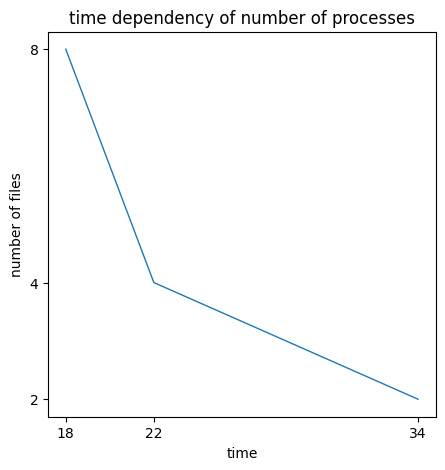

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_xlabel('time')
ax.set_ylabel('number of files')
ax.set_title('time dependency of number of processes')
ax.set_yticks([2,4,8])
ax.set_xticks([34, 22, 18])

ax.plot([34, 22, 18], [2,4,8], linewidth=1)
None

Чем больше разбиений на отдельные файлы, тем быстрее работает функция
---

8\. Напишите функцию `parallel_map`, которая принимает на вход серию `s` `pd.Series` и функцию одного аргумента `f` и поэлементно применяет эту функцию к серии, распараллелив вычисления при помощи пакета `multiprocessing`. Логика работы функции `parallel_map` должна включать следующие действия:
* разбиение исходной серии на $K$ частей, где $K$ - количество ядер вашего процессора;
* параллельное применение функции `f` к каждой части при помощи метода _серии_ `map` при помощи нескольких подпроцессов;
* объединение результатов работы подпроцессов в одну серию. 

In [2]:
%%file parallel_map.py
import multiprocessing
import pandas as pd

def parallel_map(s: pd.Series, f: callable) -> pd.Series:
    with multiprocessing.Pool(processes=8) as pool:
        res = pd.Series(pool.map(f, s))
    return res

Overwriting parallel_map.py


9\. Напишите функцию `f`, которая принимает на вход тэг и проверяет, удовлетворяет ли тэг следующему шаблону: `[любое число]-[любое слово]-or-less`. Возьмите любой фрагмент файла, полученный в задании 1, примените функцию `f` при помощи `parallel_map` к столбцу `tags` и посчитайте количество тэгов, подходящих под этот шаблон. Решите ту же задачу, воспользовавшись методом _серий_ `map`. Сравните время и результат выполнения двух решений.

In [3]:
%%file f.py
import re

def f(tag: str) -> bool:
    import re
    if type(tag) != str:
        return False
    else:
        pattern = re.compile(r"[0-9]+-[a-zA-Z]+-or-less")
        return bool(pattern.findall(tag))

Writing f.py


In [4]:
import pandas as pd
path = 'C://Users//icom1//OneDrive - icom//Рабочий стол//TOBD_datasets//'
tags = pd.read_csv(path+'tag_nsteps_6.csv')
tags.head(2)

,tags,n_steps
0,15-minutes-or-less,3
1,easter,1


In [5]:
from parallel_map import parallel_map

In [6]:
from f import f

In [7]:
%%time
t = tags.tags.dropna()
parallel_map(t, f)

CPU times: total: 6.48 s
Wall time: 9.29 s


0           True
1          False
2          False
3          False
4          False
           ...  
8863530    False
8863531    False
8863532    False
8863533    False
8863534    False
Length: 8863535, dtype: bool

In [5]:
%%time
tags[tags.tags.map(f)].tags.count()

CPU times: total: 10.3 s
Wall time: 10.3 s


256338

10\. Используя пакет `pandarallel`, примените функцию `f` из задания 9 к столбцу `tags` таблицы, с которой вы работали этом задании. Посчитайте количество тэгов, подходящих под описанный шаблон. Измерьте время выполнения кода. Выведите на экран полученный результат.

In [13]:
%%time
from pandarallel import pandarallel
tags[tags.tags.parallel_map(f)].tags.count()

CPU times: total: 844 ms
Wall time: 6.67 s


256338